In [1]:
import pandas as pd
import glob
from tariffs import BlueTariff, GreenTariff
from sko.PSO import PSO
from sko.GA import GA
from dominio import Dominio
from current_calculator import RecommendationCalculator
from bio_inspired_calc import BioInspiredRecomendation

In [2]:
sheets_dir = 'sheets/'
excel_files_pattern = f"{sheets_dir}/*.xls*"
excel_files = glob.glob(excel_files_pattern)

cols = ['year','month','peak_consumption_in_kwh','off_peak_consumption_in_kwh','peak_measured_demand_in_kw','off_peak_measured_demand_in_kw','contract_peak_demand_in_kw','contract_off_peak_demand_in_kw',"cost_reais", 'peak_exceeded_in_kw','off_peak_exceeded_in_kw', 'none']

excel_file = {}

for filepath in excel_files:
    print('reading ' + filepath)
    file = pd.read_excel(filepath, sheet_name=None, thousands='.', decimal=',', names=cols, header=4)
    excel_file.update(file)

print('Done!')

months = {
    "Janeiro": 1,
    "Fevereiro": 2,
    "Março": 3,
    "Abril": 4,
    "Maio": 5,
    "Junho": 6,
    "Julho": 7,
    "Agosto": 8,
    "Setembro": 9,
    "Outubro": 10,
    "Novembro": 11,
    "Dezembro": 12
}

for k in excel_file:
    #print('Converting to data/' + k + '.csv')
    excel_file[k].drop(columns=['none'], inplace=True)
    excel_file[k].fillna(0, inplace=True)
    excel_file[k].month = excel_file[k].month.map(months)        
    #excel_file[k].to_csv("data/" + k + ".csv")

print('Total: ' + str(len(excel_file)))

reading sheets/UFPR.xlsx
reading sheets/UFMG_I.xlsx
reading sheets/UFSJ.xlsx
reading sheets/UFAL.xlsx
reading sheets/UFMS.xlsx
reading sheets/UFFS.xlsx
reading sheets/UFMG_II.xlsx
reading sheets/UFCA.xlsx
Done!
Total: 97


In [3]:
mods = {}
for k in excel_file:
    columns_to_check = ['contract_peak_demand_in_kw', 'contract_off_peak_demand_in_kw']

    # Check if both columns have only zeros
    both_zero_conditions = excel_file[k][columns_to_check].eq(0).all(axis=0)
    both_zero_columns = both_zero_conditions[both_zero_conditions].index.tolist()

    # Check if each column has only zeros
    peak_demand_zero_condition = excel_file[k]['contract_peak_demand_in_kw'].eq(0).all()
    off_peak_demand_zero_condition = excel_file[k]['contract_off_peak_demand_in_kw'].eq(0).all()

    flag = ''
    if peak_demand_zero_condition and not off_peak_demand_zero_condition:
        flag = 'Green'
    elif off_peak_demand_zero_condition and not peak_demand_zero_condition:
        flag = 'Green'
        excel_file[k][['contract_off_peak_demand_in_kw']] = excel_file[k][['contract_peak_demand_in_kw']]
    else:
        flag = 'Blue'

    mod = {k: flag}
    mods.update(mod)
    

In [4]:
import warnings

# To ignore all warnings
warnings.filterwarnings('ignore')

RESULT_HEADERS = ['method', 'flag', 'peak', 'off_peak', 'unique', 'cost', 'num_months', 'time']
N = [6, 8, 12, 18, 24, 30]
result_list = {}
for n in N:
    print('   Running for ' + str(n) + ' months in history:\n')
    results = {}
    for k in excel_file:
        print("UC " + k + ":")
        result_frame = pd.DataFrame(columns=RESULT_HEADERS)
    
        if len(excel_file[k]) < n + 2:
            print('  Size: ' + str(len(excel_file[k])) + ' Discarted for now...')
            continue
        
        cm = RecommendationCalculator(excel_file[k].head(n), mods[k], BlueTariff(), GreenTariff(), n)
        result_frame.loc[len(result_frame)] = cm.calculate()

        bio_inspired = BioInspiredRecomendation(n, excel_file[k])

        result_frame.loc[len(result_frame)] = bio_inspired.do_PSO()

        result_frame.loc[len(result_frame)] = bio_inspired.do_GA()

        results[k] = result_frame

    result_list.update({n: results})

print("Done!")

   Running for 6 months in history:

UC 1936654:
UC 1936905:
UC 1940058:
UC 6882102:
UC 19450729:
UC 25579096:
UC 25579126:
UC 26657635:
UC 28362136:
UC 32767706:
UC 33261296:
UC 41059611:
UC 41322649:
UC 44860480:
UC 44869940:
UC 44895780:
UC 47953187:
UC 51289970:
UC 54587131:
UC 69860726:
UC 79888534:
UC 87125480:
UC 99476223:
UC 102704724:
UC Escola d Belas Artes-7000081725:
UC Fábrica de ração -  7000038106:
UC Faculdade d Educação-7000081731:
UC Faculdade Farmácia - 7000081775:
UC Faculdade de odonto-7000081710:
UC Fazenda modelo - 7000081761:
UC ICB bloco C - 7000081747:
UC ICB bloco E - 7000081747 :
UC ICB bloco K - 7000081747:
UC Instituto de Ciencias7000038219:
UC Lab d Estudo d Combu-7000081716:
UC Lab de Nanomateriais 7000081716:
UC Lab laqquacultura 7000081750:
UC Museu de história 7000038187:
UC Restaurante 1 - 7000081789:
UC Restaurante 2 - 7000081789:
UC Túnel do vento 7000081761:
UC UFMG CAD 2 - 7000081789:
UC Centro d Microscopia 7000081789:
UC UFMG CÉU - 7000081789:


In [50]:
ECO_HEADERS = ['method', 'cost']
PERF_HEADERS = ['method', 'MAPE', 'time']
methods = {0: 'current', 1: 'PSO', 2:'GA'}

final_perfs = {}
for R in result_list:
    results = result_list[R]
    start_i = R
    economy, perf = {}, {}
    elapsed = [2, 4, 6]
    
    for e in elapsed:
        inter = pd.DataFrame(columns=PERF_HEADERS)
        pso_data, ga_data, cur_data = [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]
    
        num_uc = 0
        for r in results:
            if len(excel_file[r]) < start_i + e:
                continue
        
            #print ("Economy UC " + r + ": " + str(start_i))

            result = results[r]

            cur_data[1] += result['time'][0]
            pso_data[1] += result['time'][1]
            ga_data[1] += result['time'][2]
        
            economy_frame = pd.DataFrame(columns=ECO_HEADERS)
    
            next_months = excel_file[r].loc[start_i:start_i+e+1]

            Dominio().insert_new_history(next_months)

            for i in range(0, 3):
                if result['flag'][i] == 'Skiped':
                    continue
                elif result['flag'][i] == 'Green' or result['flag'][i] == 'Verde':
                    res = round(Dominio().green_objective_func([result['unique'][i]]), 2)
                    economy_frame.loc[i] = [methods[i], res]
                else:
                    res = round(Dominio().blue_objective_func([result['peak'][i], result['off_peak'][i]]), 2)
                    economy_frame.loc[i] = [methods[i], res]                

            real = round(Dominio().green_real_value(), 2) if mods[r] == 'Green' else round(Dominio().blue_real_value(), 2)
            economy_frame.loc[3] = ['REAL', real]

            cur_data[0] += (real - economy_frame['cost'][0])/real
            pso_data[0] += (real - economy_frame['cost'][1])/real
            ga_data[0] += (real - economy_frame['cost'][2])/real
        
            num_uc += 1
        
            economy[r] = economy_frame

        cur_data[0] = 100 * (cur_data[0]/num_uc) 
        pso_data[0] = 100 * (pso_data[0]/num_uc)
        ga_data[0] = 100 * (ga_data[0]/num_uc)

        cur_data[1] /= num_uc
        pso_data[1] /= num_uc
        ga_data[1] /= num_uc

        inter.loc[0] = ['Current', cur_data[0], cur_data[1]]
        inter.loc[1] = ['PSO', pso_data[0], pso_data[1]]
        inter.loc[2] = ['GA', ga_data[0], ga_data[1]]

        perf.update({e: [inter, num_uc]})

    final_perfs.update({R: perf})

print("DONE!")

DONE!


In [6]:
for N in final_perfs:
    print('USANDO ' + str(N) + ' MESES DE HISTÓRICO')
    for p in final_perfs[N]:
        perform = final_perfs[N][p]
        print(str(p) + ' meses futuros:  (' + str(perform[1]) + ') UCs')
        #display(perform[0])
    print('--------------------------------\n')

USANDO 6 MESES DE HISTÓRICO
2 meses futuros:  (97) UCs


,method,MAPE,time
0,Current,156.183319,0.000035
1,PSO,30.469251,1.012940
2,GA,30.316687,1.065789


4 meses futuros:  (97) UCs


,method,MAPE,time
0,Current,184.070446,0.000035
1,PSO,29.227117,1.012940
2,GA,29.271670,1.065789


6 meses futuros:  (96) UCs


,method,MAPE,time
0,Current,554.008931,0.000035
1,PSO,29.194924,1.007625
2,GA,29.261442,1.064655


--------------------------------

USANDO 8 MESES DE HISTÓRICO
2 meses futuros:  (97) UCs


,method,MAPE,time
0,Current,262.820581,0.000033
1,PSO,34.666565,1.265432
2,GA,34.666565,1.178223


4 meses futuros:  (96) UCs


,method,MAPE,time
0,Current,592.837634,0.000033
1,PSO,34.311518,1.265257
2,GA,34.311518,1.178280


6 meses futuros:  (26) UCs


,method,MAPE,time
0,Current,1703.059050,0.000034
1,PSO,15.327058,1.277929
2,GA,15.327058,1.201382


--------------------------------

USANDO 12 MESES DE HISTÓRICO
2 meses futuros:  (26) UCs


,method,MAPE,time
0,Current,1489.854312,0.000030
1,PSO,20.967126,1.739048
2,GA,20.844868,1.390251


4 meses futuros:  (23) UCs


,method,MAPE,time
0,Current,1686.382718,0.000031
1,PSO,16.203546,1.730145
2,GA,16.052937,1.385961


6 meses futuros:  (23) UCs


,method,MAPE,time
0,Current,1690.523873,0.000031
1,PSO,16.464510,1.730145
2,GA,16.320015,1.385961


--------------------------------

USANDO 18 MESES DE HISTÓRICO
2 meses futuros:  (23) UCs


,method,MAPE,time
0,Current,29.210122,0.000029
1,PSO,24.428497,2.455194
2,GA,26.567161,1.723418


4 meses futuros:  (23) UCs


,method,MAPE,time
0,Current,27.946439,0.000029
1,PSO,22.980104,2.455194
2,GA,25.040284,1.723418


6 meses futuros:  (22) UCs


,method,MAPE,time
0,Current,26.184253,0.000029
1,PSO,23.135381,2.455756
2,GA,23.091606,1.721984


--------------------------------

USANDO 24 MESES DE HISTÓRICO
2 meses futuros:  (14) UCs


,method,MAPE,time
0,Current,400.733085,0.000031
1,PSO,371.052674,3.317562
2,GA,371.897595,2.159463


4 meses futuros:  (14) UCs


,method,MAPE,time
0,Current,400.882535,0.000031
1,PSO,371.366281,3.317562
2,GA,372.208445,2.159463


6 meses futuros:  (14) UCs


,method,MAPE,time
0,Current,400.957260,0.000031
1,PSO,371.523078,3.317562
2,GA,372.363873,2.159463


--------------------------------

USANDO 30 MESES DE HISTÓRICO
2 meses futuros:  (14) UCs


,method,MAPE,time
0,Current,390.349324,0.000029
1,PSO,350.331522,4.089077
2,GA,346.614815,2.590136


4 meses futuros:  (14) UCs


,method,MAPE,time
0,Current,390.423860,0.000029
1,PSO,350.488826,4.089077
2,GA,346.773570,2.590136


6 meses futuros:  (14) UCs


,method,MAPE,time
0,Current,31.836596,0.000029
1,PSO,34.762368,4.089077
2,GA,34.229898,2.590136


--------------------------------



In [51]:
bateladas = [6, 8, 12, 18, 24, 30]
cur, pso, ga = [], [], []
ucs_data = {}

for N in final_perfs:
    ucs_per_f = {}
    for p in final_perfs[N]:
        ucs_per_f.update({p:final_perfs[N][p][1]})
        perform = final_perfs[N][p][0]
        cur.append(perform['MAPE'][0])
        pso.append(perform['MAPE'][1])
        ga.append(perform['MAPE'][2])
        
    ucs_data.update({N:ucs_per_f})

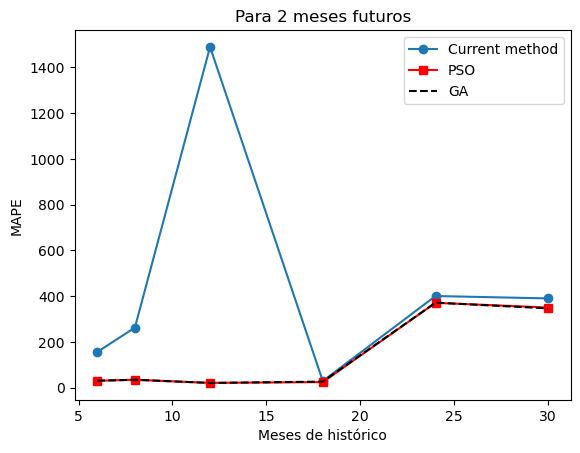

In [8]:
import matplotlib.pyplot as plt

plt.plot(bateladas, cur[0:18:3], 'o-', label='Current method')
plt.plot(bateladas, pso[0:18:3], 'rs-', label='PSO')
plt.plot(bateladas, ga[0:18:3], 'k', label='GA', linestyle='dashed')

# Adding labels and title
plt.xlabel('Meses de histórico')
plt.ylabel('MAPE')
plt.title('Para 2 meses futuros')
plt.legend()

# Display the plot
plt.show()


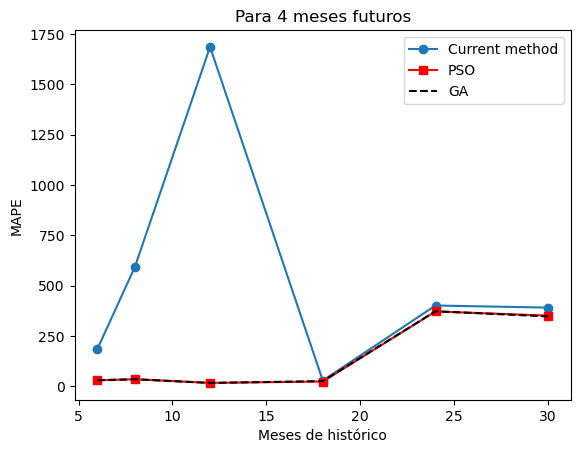

In [14]:
import matplotlib.pyplot as plt

plt.plot(bateladas, cur[1:18:3], 'o-', label='Current method')
plt.plot(bateladas, pso[1:18:3], 'rs-', label='PSO')
plt.plot(bateladas, ga[1:18:3], 'k', label='GA', linestyle='dashed')

# Adding labels and title
plt.xlabel('Meses de histórico')
plt.ylabel('MAPE')
plt.title('Para 4 meses futuros')
plt.legend()

# Display the plot
plt.show()


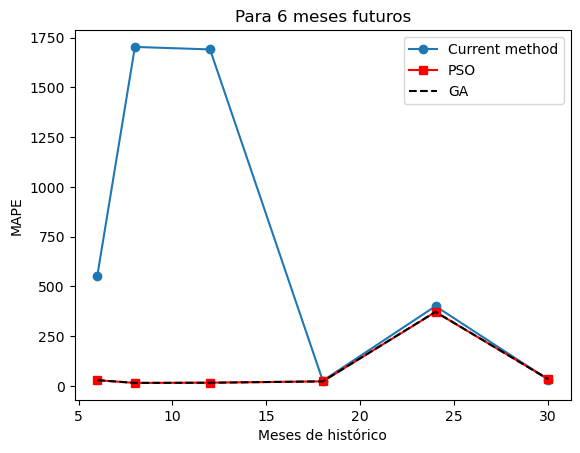

In [13]:
import matplotlib.pyplot as plt

plt.plot(bateladas, cur[2:18:3], 'o-', label='Current method')
plt.plot(bateladas, pso[2:18:3], 'rs-', label='PSO')
plt.plot(bateladas, ga[2:18:3], 'k', label='GA', linestyle='dashed')

# Adding labels and title
plt.xlabel('Meses de histórico')
plt.ylabel('MAPE')
plt.title('Para 6 meses futuros')
plt.legend()

# Display the plot
plt.show()

In [17]:
bateladas = [6, 8, 12, 18, 24, 30]
cur_t, pso_t, ga_t = [], [], []

for N in final_perfs:
    for p in final_perfs[N]:
        perform = final_perfs[N][p][0]
        cur_t.append(perform['time'][0])
        pso_t.append(perform['time'][1])
        ga_t.append(perform['time'][2])

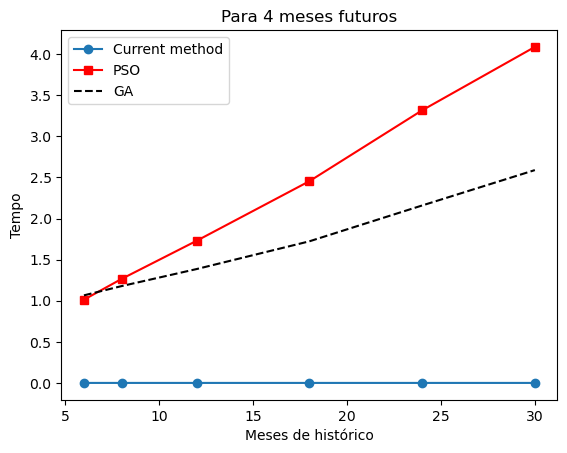

In [20]:
import matplotlib.pyplot as plt

plt.plot(bateladas, cur_t[1:18:3], 'o-', label='Current method')
plt.plot(bateladas, pso_t[1:18:3], 'rs-', label='PSO')
plt.plot(bateladas, ga_t[1:18:3], 'k', label='GA', linestyle='dashed')

# Adding labels and title
plt.xlabel('Meses de histórico')
plt.ylabel('Tempo')
plt.title('Para 4 meses futuros')
plt.legend()

# Display the plot
plt.show()

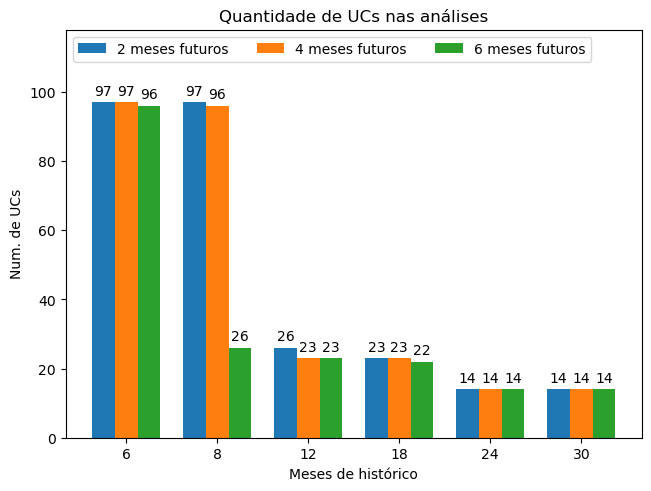

In [47]:
import numpy as np

ucs_g = {'2 meses futuros':[], '4 meses futuros':[], '6 meses futuros':[]}
for i in ucs_data:
    for k in ucs_data[i]:
        ucs_g[str(k) + ' meses futuros'].append(ucs_data[i][k])

x = np.arange(len(bateladas))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for future, measurement in ucs_g.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=future)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Num. de UCs')
ax.set_xlabel('Meses de histórico')
ax.set_title('Quantidade de UCs nas análises')
ax.set_xticks(x + width, bateladas)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 118)

plt.show()    

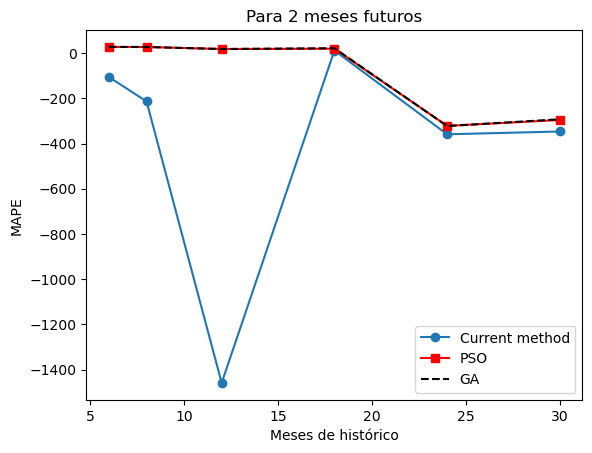

In [52]:
import matplotlib.pyplot as plt

plt.plot(bateladas, cur[0:18:3], 'o-', label='Current method')
plt.plot(bateladas, pso[0:18:3], 'rs-', label='PSO')
plt.plot(bateladas, ga[0:18:3], 'k', label='GA', linestyle='dashed')

# Adding labels and title
plt.xlabel('Meses de histórico')
plt.ylabel('MAPE')
plt.title('Para 2 meses futuros')
plt.legend()

# Display the plot
plt.show()